In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import shap
import ipywidgets
import torch
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            roc_curve, auc, f1_score, 
                            roc_auc_score,confusion_matrix, 
                            classification_report)

In [ ]:
#Конкатенация собранных .csv файлов в один
data_direction = Path("/Users/sasha/Documents/Kickstarter2024/")
df = pd.concat([pd.read_csv(f) for f in data_direction.glob("*.csv")], ignore_index=True)
df.to_csv("/Users/Sasha/Documents/dataframe.csv", index=False)

In [5]:
#Чтение файла
path = '/Users/sasha/Documents/dataframe.csv'
data = pd.read_csv(path)
data.info()
data.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231290 entries, 0 to 231289
Data columns (total 42 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   backers_count                       231290 non-null  int64  
 1   blurb                               231278 non-null  object 
 2   category                            231290 non-null  object 
 3   converted_pledged_amount            220390 non-null  float64
 4   country                             231290 non-null  object 
 5   country_displayable_name            231290 non-null  object 
 6   created_at                          231290 non-null  int64  
 7   creator                             231290 non-null  object 
 8   currency                            231290 non-null  object 
 9   currency_symbol                     231290 non-null  object 
 10  currency_trailing_code              231290 non-null  bool   
 11  current_currency          

['backers_count',
 'blurb',
 'category',
 'converted_pledged_amount',
 'country',
 'country_displayable_name',
 'created_at',
 'creator',
 'currency',
 'currency_symbol',
 'currency_trailing_code',
 'current_currency',
 'deadline',
 'disable_communication',
 'fx_rate',
 'goal',
 'id',
 'is_disliked',
 'is_in_post_campaign_pledging_phase',
 'is_launched',
 'is_liked',
 'is_starrable',
 'launched_at',
 'location',
 'name',
 'percent_funded',
 'photo',
 'pledged',
 'prelaunch_activated',
 'profile',
 'slug',
 'source_url',
 'spotlight',
 'staff_pick',
 'state',
 'state_changed_at',
 'static_usd_rate',
 'urls',
 'usd_exchange_rate',
 'usd_pledged',
 'usd_type',
 'video']

In [ ]:
#чистка датасета от нерелевантных признаков
df_clear = data.drop(['backers_count', 'converted_pledged_amount', 'country_displayable_name',
                      'creator', 'currency', 'currency_symbol', 'currency_trailing_code',
                      'current_currency', 'disable_communication', 'fx_rate',
                      'id', 'is_disliked', 'is_liked', 'is_launched',
                      'is_in_post_campaign_pledging_phase', 'is_starrable', 'name',
                      'percent_funded', 'photo', 'pledged', 'profile', 'spotlight', 
                      'slug', 'source_url', 'state_changed_at', 'static_usd_rate', 'urls',
                       'usd_exchange_rate', 'usd_pledged', 'usd_type'], axis=1)
df_clear.columns.tolist()


['blurb',
 'category',
 'country',
 'created_at',
 'deadline',
 'goal',
 'launched_at',
 'location',
 'prelaunch_activated',
 'staff_pick',
 'state',
 'video']

In [ ]:
#переименовывание признаков
df_clear.at[20,'location']
df_clear = df_clear.rename(columns={'blurb': 'Текст', 'category': 'Категория',
                                    'country': 'Страна', 'goal': 'Цель',
                                    'location': 'Город', 'prelaunch_activated': 'РаннийЗапуск',
                                    'staff_pick': 'ВыборПлощадки', 'state': 'Результат',
                                    'video': 'Видео'})


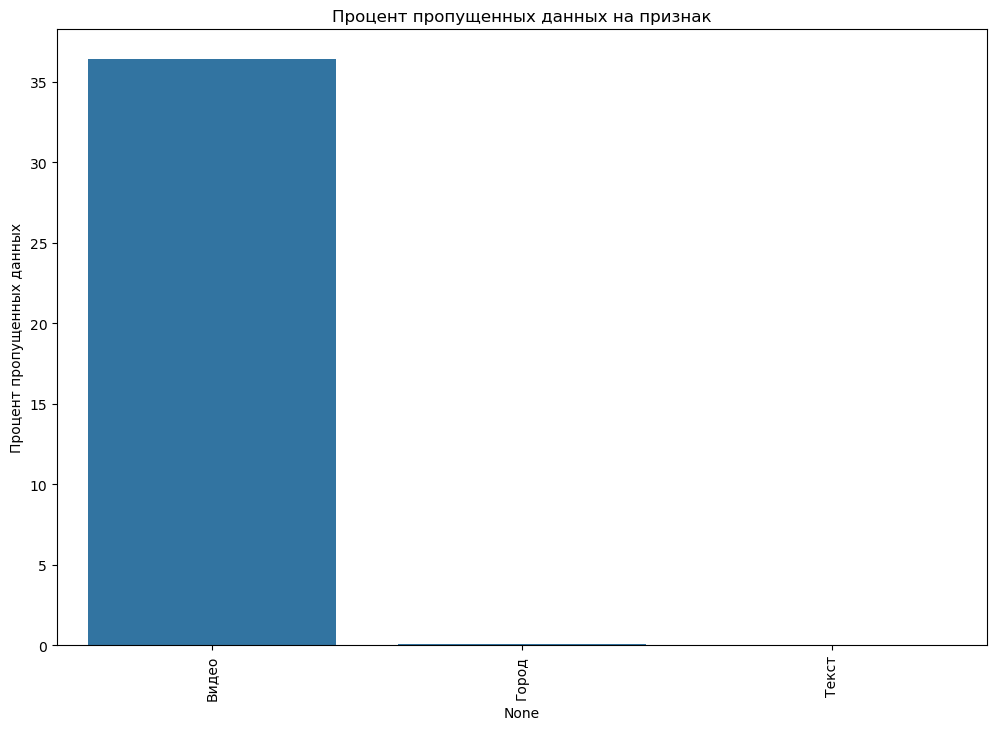

In [ ]:
#процентное соотношение пропущенных значений
df_nans = (df_clear.isnull().sum() / len(df_clear)) * 100
df_nans = df_nans.drop(df_nans[df_nans == 0].index).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation=90)
sns.barplot(x=df_nans.index, y=df_nans)
ax.set(title='Процент пропущенных данных на признак', ylabel='Процент пропущенных данных')
plt.show()

In [9]:
df_clear['Видео'] = df_clear['Видео'].fillna(0)
df_clear = df_clear.dropna()

In [ ]:
#подготовка признака категории
def extract_parent_name(cell):
    try:
        data1 = ast.literal_eval(cell) if isinstance(cell, str) else cell
        return data1.get('parent_name')
    except (ValueError, SyntaxError, AttributeError):
        import re
        match = re.search(r"'parent_name'\s*:\s*'([^']+)'", str(cell))
        if not match:
            match = re.search(r'"parent_name"\s*:\s*"([^"]+)"', str(cell))
        return match.group(1) if match else None

df_clear['Категория'] = df_clear['Категория'].apply(extract_parent_name)
df_clear = df_clear.dropna()

In [ ]:
#подготовка признаков город и видео
def extract_location_name(cell):
    try:
        data2 = ast.literal_eval(cell) if isinstance(cell, str) else cell
        return data2.get('name')
    except (ValueError, SyntaxError, AttributeError):
        import re
        match = re.search(r"'name'\s*:\s*'([^']+)'", str(cell)) or \
               re.search(r'"name"\s*:\s*"([^"]+)"', str(cell))
        return match.group(1) if match else None

df_clear['Город'] = df_clear['Город'].apply(extract_location_name)
df_clear['Видео'] = np.where(df_clear['Видео'] == 0, 0, 1)

In [ ]:
#подготовка признаков длительности кампании и длительности подготовки
display(df_clear.iloc[[183540]].T)
df_clear['Длительность'] = (df_clear['deadline'] - df_clear['launched_at']) // 86400
df_clear['ДлительностьПодготовки'] = (df_clear['launched_at'] - df_clear['created_at']) // 86400
df_clear = df_clear.drop(['launched_at', 'created_at', 'deadline'], axis=1)


,187550
Текст,"Sex, superheroes and The B-Mecha Babe."
Категория,Comics
Страна,GB
created_at,1701269665
deadline,1706831940
Цель,500.0
launched_at,1704844843
Город,Leeds
РаннийЗапуск,True
ВыборПлощадки,False


In [ ]:
df_clear[['РаннийЗапуск', 'ВыборПлощадки']] = df_clear[['РаннийЗапуск', 'ВыборПлощадки']].astype(int)

In [14]:
df_clear['Результат'] = df_clear['Результат'].replace({
    'successful': 1,
    'failed': 0,
    'canceled': 0,
    'submitted': 2,
    'live': 2,
    'started': 2,
    'suspended': 2
    })
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226465 entries, 0 to 231289
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Текст                   226465 non-null  object 
 1   Категория               226465 non-null  object 
 2   Страна                  226465 non-null  object 
 3   Цель                    226465 non-null  float64
 4   Город                   226465 non-null  object 
 5   РаннийЗапуск            226465 non-null  int64  
 6   ВыборПлощадки           226465 non-null  int64  
 7   Результат               226465 non-null  int64  
 8   Видео                   226465 non-null  int64  
 9   Длительность            226465 non-null  int64  
 10  ДлительностьПодготовки  226465 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 20.7+ MB


/var/folders/y2/5f5q9gyx5vl7rvw62zdg_ywr0000gn/T/ipykernel_11755/176020957.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clear['Результат'] = df_clear['Результат'].replace({


In [15]:
state_counts = df_clear['Результат'].value_counts()
state_percentage = df_clear['Результат'].value_counts(normalize=True) * 100

state_stats = pd.DataFrame({
    'Count': state_counts,
    'Percentage': state_percentage
})

print(state_stats)

            Count  Percentage
Результат                    
1          129826   57.327181
0           81257   35.880600
2           15382    6.792220


In [16]:
df_clear = df_clear[df_clear['Результат'] != 2]

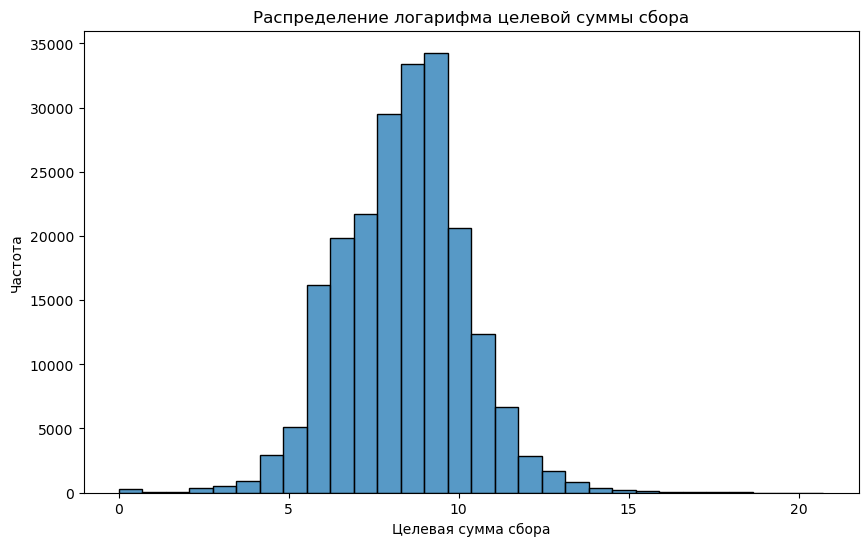

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_clear['Цель']), kde=False, bins=30)
plt.title('Распределение логарифма целевой суммы сбора')
plt.xlabel('Целевая сумма сбора')
plt.ylabel('Частота')
plt.show()

In [18]:
numeric_features = ['Цель', 'Длительность', 'ДлительностьПодготовки']
success_stats = df_clear.groupby('Результат')[numeric_features].agg(['mean', 'median'])
print("\nСравнение средних и медиан:")
print(success_stats)


Сравнение средних и медиан:
                    Цель         Длительность        ДлительностьПодготовки  \
                    mean  median         mean median                   mean   
Результат                                                                     
0          128529.580575  7500.0    36.388668   30.0              43.073286   
1           17866.374216  3500.0    31.072266   30.0              58.752700   

                  
          median  
Результат         
0            7.0  
1           18.0  


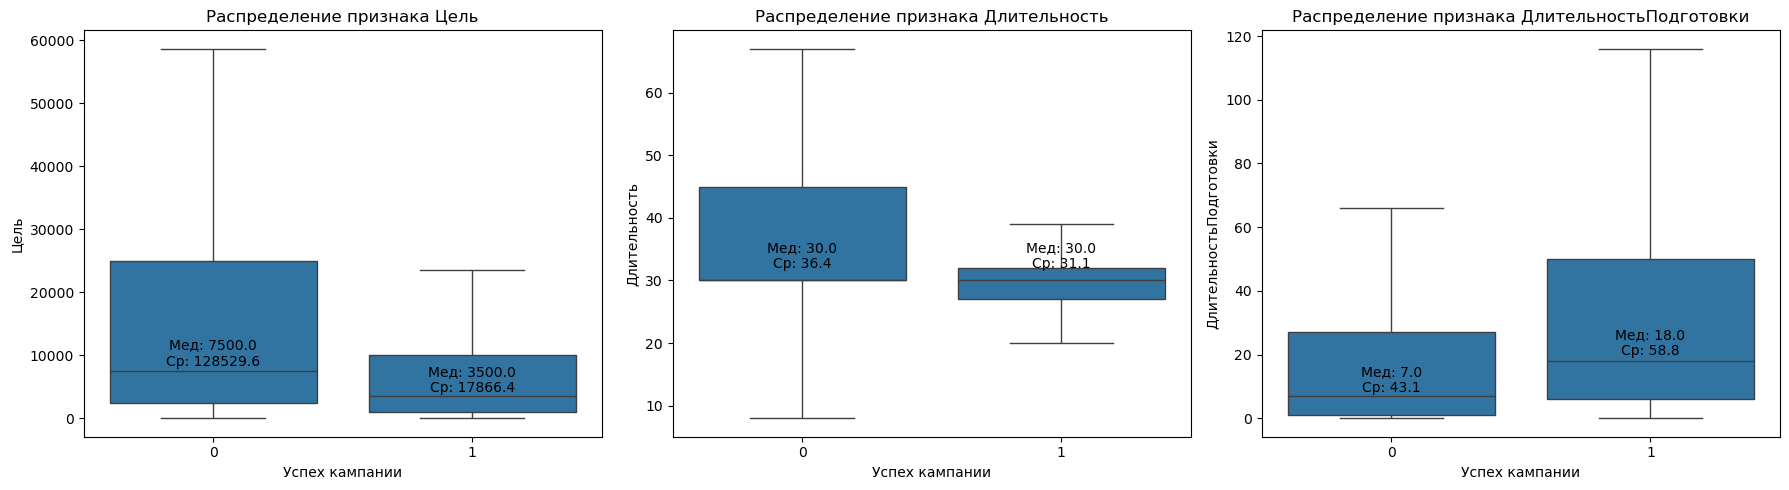

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#ящик с усами для каждого признака
for i, feature in enumerate(numeric_features):
    sns.boxplot(x='Результат', y=feature, data=df_clear, ax=axes[i], showfliers=False)
    axes[i].set_title(f'Распределение признака {feature}')
    axes[i].set_xlabel('Успех кампании')
    axes[i].set_ylabel(feature)
    
    #Аннотации со средними и медианами
    for status in [0, 1]:
        median = df_clear[df_clear['Результат'] == status][feature].median()
        mean = df_clear[df_clear['Результат'] == status][feature].mean()
        axes[i].text(status, median*1.05, f'Мед: {median:.1f}\nСр: {mean:.1f}', 
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

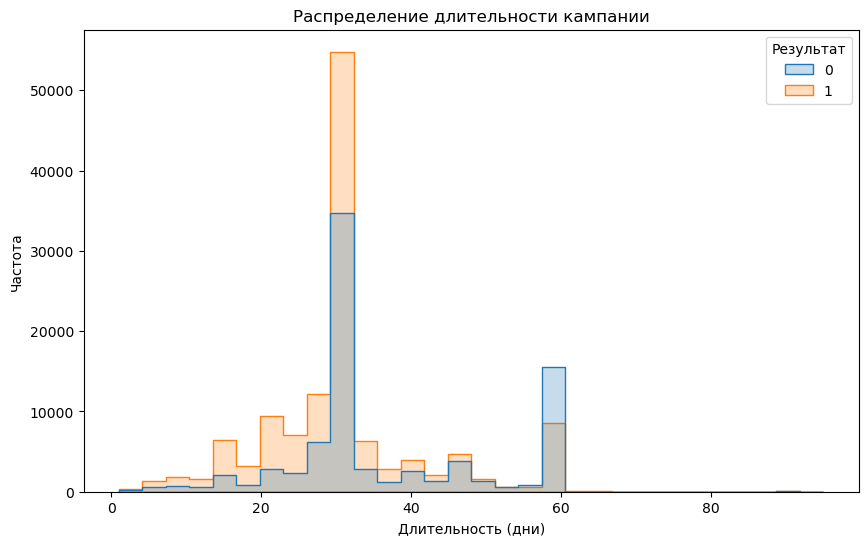

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_clear, x='Длительность', hue='Результат', bins=30, kde=False, element='step')
plt.title('Распределение длительности кампании')
plt.xlabel('Длительность (дни)')
plt.ylabel('Частота')
plt.show()

/var/folders/y2/5f5q9gyx5vl7rvw62zdg_ywr0000gn/T/ipykernel_11755/855205126.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_success.index, y='success_rate', data=category_success, palette='viridis')


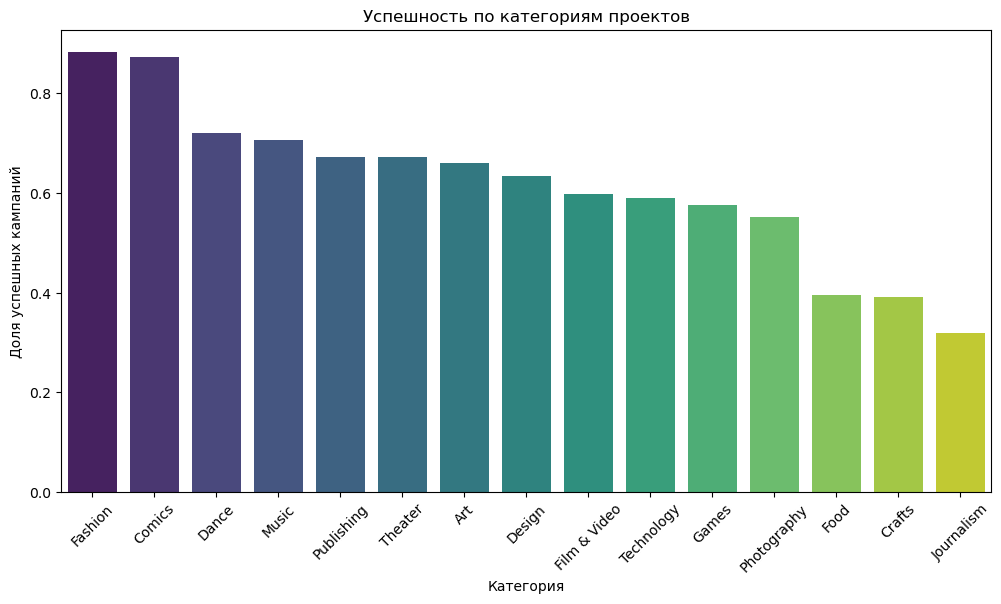

In [21]:
category_success = df_clear.groupby(['Категория', 'Результат']).size().unstack().fillna(0)
category_success['success_rate'] = category_success[1] / (category_success[0] + category_success[1])
category_success = category_success.sort_values('success_rate', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=category_success.index, y='success_rate', data=category_success, palette='viridis')
plt.title('Успешность по категориям проектов')
plt.xlabel('Категория')
plt.ylabel('Доля успешных кампаний')
plt.xticks(rotation=45)
plt.show()

/var/folders/y2/5f5q9gyx5vl7rvw62zdg_ywr0000gn/T/ipykernel_11755/1042872099.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_success.index, y='mean', data=country_success, palette='coolwarm')


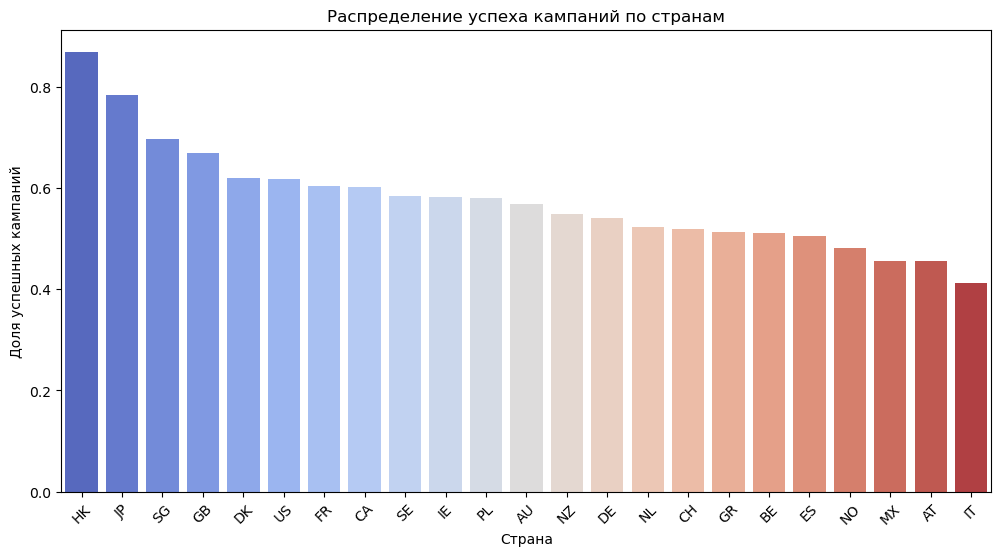

In [22]:
country_success = df_clear.groupby('Страна')['Результат'].agg(['mean', 'count'])
country_success = country_success[country_success['count'] > 100]
country_success = country_success.sort_values('mean', ascending=False).head(30)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_success.index, y='mean', data=country_success, palette='coolwarm')
plt.title('Распределение успеха кампаний по странам')
plt.xlabel('Страна')
plt.ylabel('Доля успешных кампаний')
plt.xticks(rotation=45)
plt.show()

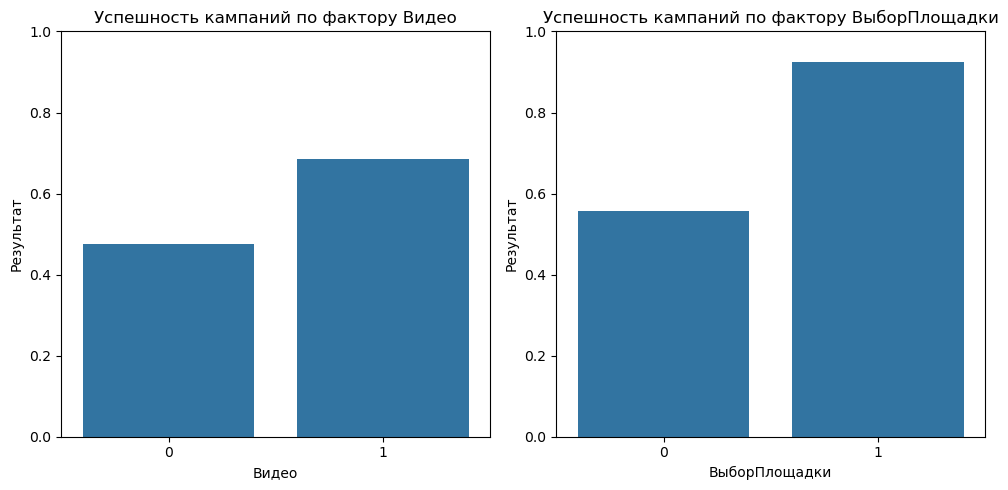

In [23]:
binary_features = ['Видео', 'ВыборПлощадки']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(binary_features, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x=feature, y='Результат', data=df_clear, errorbar=None)
    plt.title(f'Успешность кампаний по фактору {feature}')
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()

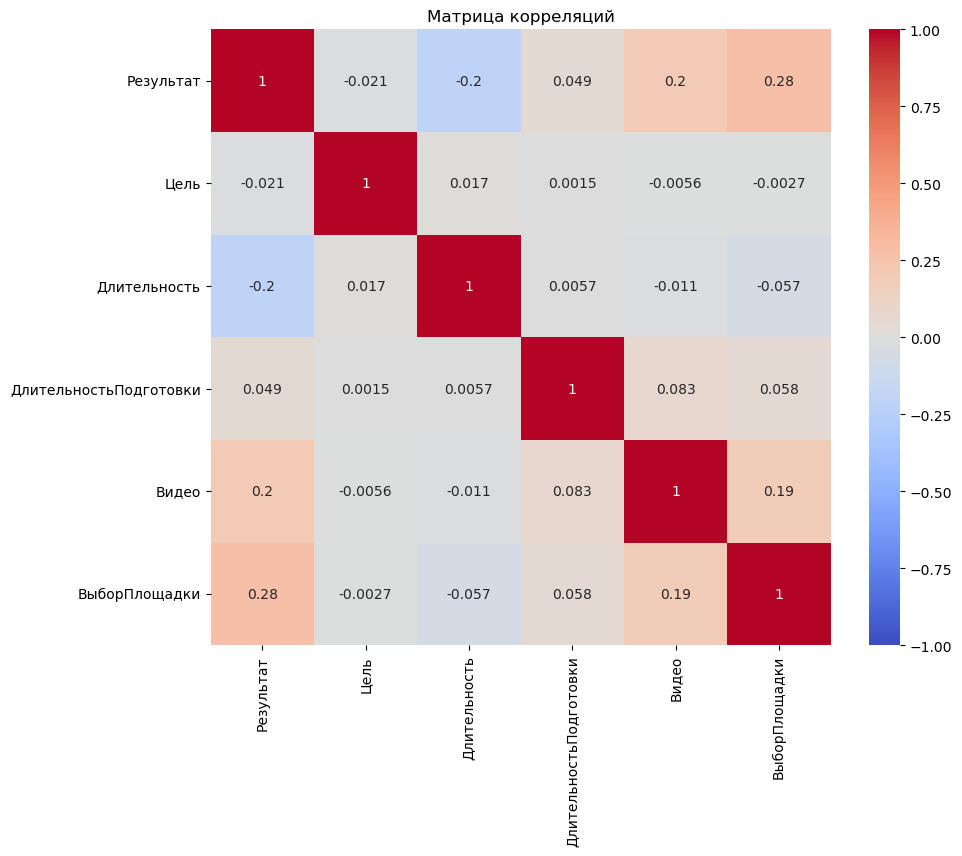

In [24]:
numerical_df = df_clear[['Результат', 'Цель', 'Длительность', 'ДлительностьПодготовки', ] + binary_features]
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

In [ ]:
df_clear['Текст'] = df_clear['Текст'].fillna('')

tfidf = TfidfVectorizer(
    max_features=1000,
    min_df=5,       
    max_df=0.8,        
    stop_words='english',
    ngram_range=(1, 2) 
)

# Применяем TF-IDF к тексту
tfidf_features = tfidf.fit_transform(df_clear['Текст'].fillna('').astype(str))

tfidf_df = pd.DataFrame(
    tfidf_features.toarray(),
    columns=tfidf.get_feature_names_out())

df_without_text = df_clear.drop('Текст', axis=1)
df_clear = pd.concat([df_without_text, tfidf_df], axis=1)
df_clear = df_clear.dropna()


In [24]:
#Предобработка данных
X = df_clear.drop('Результат', axis=1)
y = df_clear['Результат']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
#Распределение признаков по типам
cat_features = ['Категория', 'Страна', 'Город']

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features,
    feature_names=list(X_train.columns))

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features,
    feature_names=list(X_test.columns))


In [26]:
#Инициализация
model = CatBoostClassifier(
    auto_class_weights='Balanced',
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100)

In [27]:
#Обучение модели
model.fit(
    train_pool,
    eval_set=test_pool,
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7923525	best: 0.7923525 (0)	total: 243ms	remaining: 4m 2s
100:	test: 0.8578000	best: 0.8578000 (100)	total: 9.04s	remaining: 1m 20s
200:	test: 0.8619359	best: 0.8619359 (200)	total: 17.2s	remaining: 1m 8s
300:	test: 0.8644097	best: 0.8644097 (300)	total: 26.3s	remaining: 1m 1s
400:	test: 0.8652563	best: 0.8652563 (400)	total: 35.3s	remaining: 52.7s
500:	test: 0.8656861	best: 0.8656880 (497)	total: 44.1s	remaining: 43.9s
600:	test: 0.8660215	best: 0.8660215 (600)	total: 52.7s	remaining: 35s
700:	test: 0.8660637	best: 0.8660810 (679)	total: 1m 1s	remaining: 26.2s
800:	test: 0.8661059	best: 0.8661251 (781)	total: 1m 10s	remaining: 17.6s
900:	test: 0.8660809	best: 0.8661447 (830)	total: 1m 19s	remaining: 8.78s
999:	test: 0.8660941	best: 0.8661447 (830)	total: 1m 27s	remaining: 0us

bestTest = 0.86614468
bestIteration = 830

Shrink model to first 831 iterations.



Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73     14810
         1.0       0.84      0.80      0.82     23678

    accuracy                           0.78     38488
   macro avg       0.77      0.78      0.77     38488
weighted avg       0.79      0.78      0.78     38488


Metrics:
Accuracy: 0.7829
Precision: 0.8417
Recall: 0.7969
F1-score: 0.8187
ROC-AUC: 0.8661


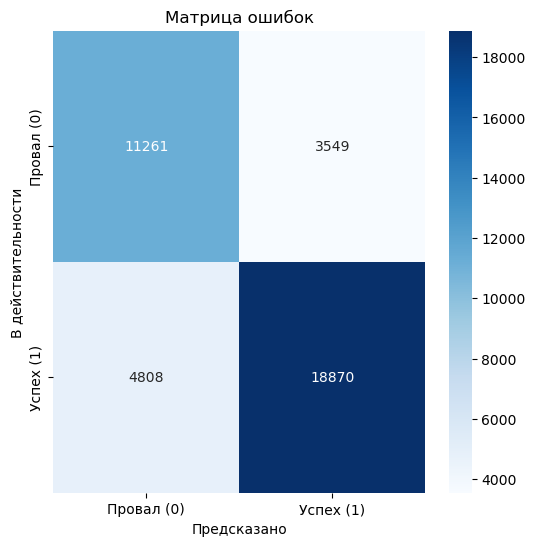

In [28]:
#Оценка качества
y_pred = model.predict(test_pool)
y_pred_proba = model.predict_proba(test_pool)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nMetrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

#Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Провал (0)', 'Успех (1)'], 
            yticklabels=['Провал (0)', 'Успех (1)'])
plt.title('Матрица ошибок')
plt.ylabel('В действительности')
plt.xlabel('Предсказано')
plt.show()

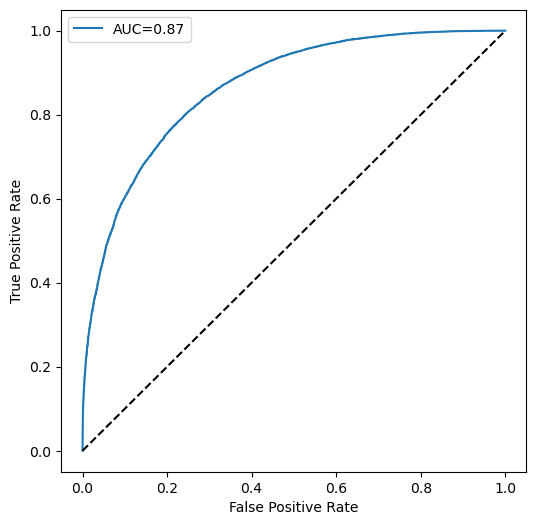

(<matplotlib.legend.Legend at 0x309ea2120>, None)

In [31]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC={auc(fpr, tpr):.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.legend(), plt.show()

/var/folders/y2/5f5q9gyx5vl7rvw62zdg_ywr0000gn/T/ipykernel_10682/2457719033.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='word', data=top_words, palette='viridis')


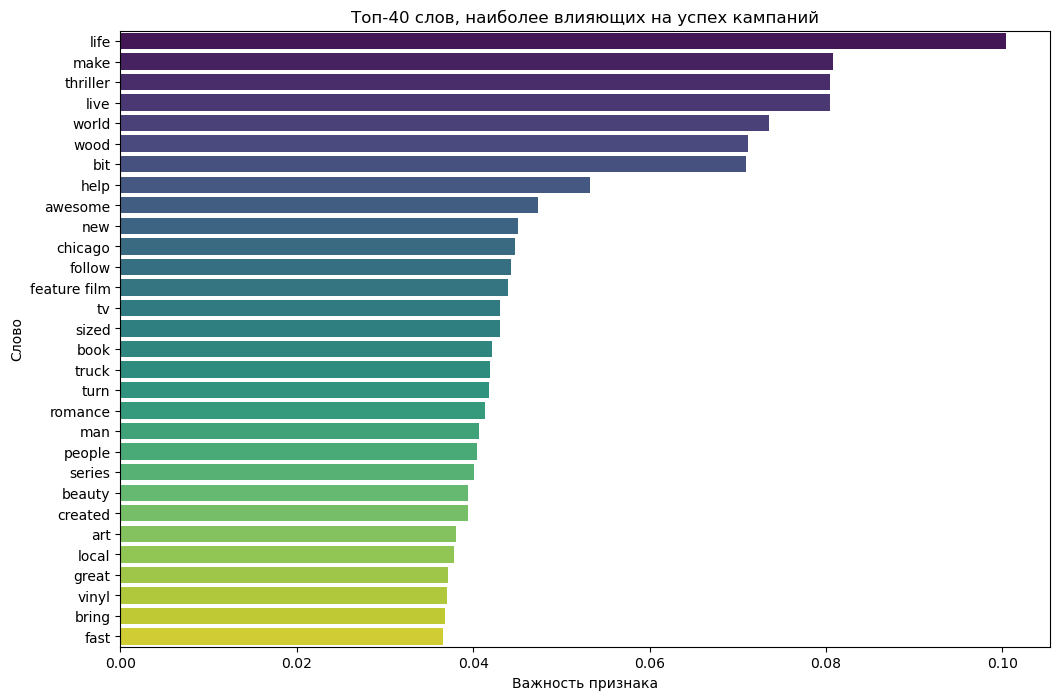

In [32]:
feature_importance = model.get_feature_importance()

word_importance = pd.DataFrame({
    'word': X_train.columns[len(df_without_text.columns)-1:],  # Только словарные фичи
    'importance': feature_importance[len(df_without_text.columns)-1:]
})

top_words = word_importance.sort_values('importance', ascending=False).head(30)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='word', data=top_words, palette='viridis')
plt.title('Топ-40 слов, наиболее влияющих на успех кампаний')
plt.xlabel('Важность признака')
plt.ylabel('Слово')
plt.show()

In [25]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
model.eval()

Using device: mps


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [26]:
def get_embeddings(texts, batch_size=64, show_progress=True):

    embeddings = []
    
    
    iter_range = range(0, len(texts), batch_size)
    if show_progress:
        iter_range = tqdm(iter_range, desc="Processing batches")
    
    for i in iter_range:
        batch = texts[i:i + batch_size]
        
        encoded = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**encoded)
        
        # Извлечение последнего скрытого слоя и усреднение по токенам (mean pooling)
        last_hidden_state = outputs.last_hidden_state
        attention_mask = encoded['attention_mask']
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        batch_embeddings = sum_embeddings / sum_mask
        
        embeddings.append(batch_embeddings.cpu().numpy())
    
    return np.concatenate(embeddings, axis=0)


In [27]:
texts = df_clear['Текст'].astype(str).tolist()
embeddings = get_embeddings(texts)

Processing batches:   0%|          | 0/3299 [00:00<?, ?it/s]

In [28]:
np.save('text_embeddings.npy', embeddings)

In [29]:
bert_columns = [f'bert_{i}' for i in range(embeddings.shape[1])]
bert_df = pd.DataFrame(embeddings, columns=bert_columns)

In [30]:
df_without_text = df_clear.drop('Текст', axis=1)
final_df = pd.concat([df_without_text, bert_df], axis=1)
final_df = final_df.dropna()

In [31]:
#Предобработка данных
X = final_df.drop('Результат', axis=1)
y = final_df['Результат']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
cat_features = ['Категория', 'Страна', 'Город']

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features,
    feature_names=list(X_train.columns))

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features,
    feature_names=list(X_test.columns))


In [33]:
#обучение с эмбеддингами

model = CatBoostClassifier(
    auto_class_weights='Balanced',
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

model.fit(
    train_pool,
    eval_set=test_pool,
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7957495	best: 0.7957495 (0)	total: 194ms	remaining: 3m 13s
100:	test: 0.8574584	best: 0.8574584 (100)	total: 11.3s	remaining: 1m 40s
200:	test: 0.8603929	best: 0.8603938 (199)	total: 20.8s	remaining: 1m 22s
300:	test: 0.8636020	best: 0.8636020 (300)	total: 30.3s	remaining: 1m 10s
400:	test: 0.8641832	best: 0.8642097 (396)	total: 40.4s	remaining: 1m
500:	test: 0.8644067	best: 0.8644188 (499)	total: 50.3s	remaining: 50.1s
600:	test: 0.8644505	best: 0.8644529 (597)	total: 59.9s	remaining: 39.7s
700:	test: 0.8645844	best: 0.8646240 (687)	total: 1m 9s	remaining: 29.6s
800:	test: 0.8645286	best: 0.8646427 (709)	total: 1m 19s	remaining: 19.8s
900:	test: 0.8644583	best: 0.8646427 (709)	total: 1m 29s	remaining: 9.84s
999:	test: 0.8645244	best: 0.8646427 (709)	total: 1m 39s	remaining: 0us

bestTest = 0.864642726
bestIteration = 709

Shrink model to first 710 iterations.



Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73     14810
         1.0       0.84      0.80      0.82     23678

    accuracy                           0.78     38488
   macro avg       0.77      0.78      0.77     38488
weighted avg       0.79      0.78      0.78     38488


Metrics:
Accuracy: 0.7823
Precision: 0.8399
Recall: 0.7983
F1-score: 0.8186
ROC-AUC: 0.8646


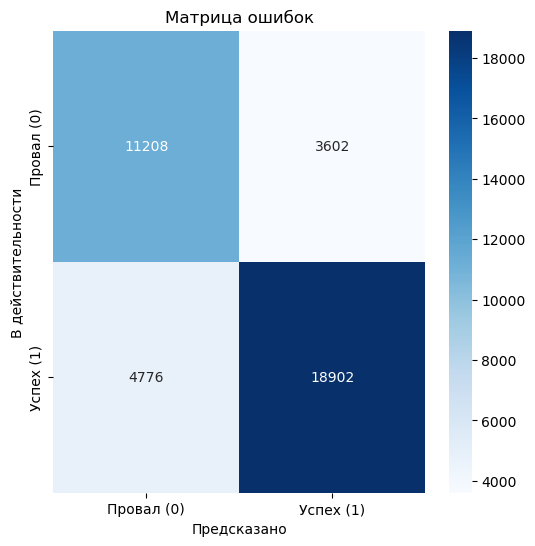

In [34]:
#оценка модели
y_pred = model.predict(test_pool)
y_pred_proba = model.predict_proba(test_pool)[:, 1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nMetrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

#Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Провал (0)', 'Успех (1)'], 
            yticklabels=['Провал (0)', 'Успех (1)'])
plt.title('Матрица ошибок')
plt.ylabel('В действительности')
plt.xlabel('Предсказано')
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC={auc(fpr, tpr):.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.legend(), plt.show()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_pool)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar Plot)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Value Distribution")
plt.tight_layout()
plt.show()

print("Force plot для одного наблюдения:")
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
